In [ ]:
# default_exp examples.multilabel_classification

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Multi-label classification

> This is an example of how to use blurr for multilabel classification tasks using both the mid and high level Blurr API

In [ ]:
#export
import os

import datasets
from transformers import *
from fastai.text.all import *
from fastai.callback.hook import _print_shapes

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

logging.set_verbosity_error()

In [ ]:
#hide_input
import pdb

from fastcore.test import *
from nbverbose.showdoc import show_doc

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("Here's what we're running with ...\n")
print_versions('torch fastai transformers')

Here's what we're running with ...

torch: 1.7.1
fastai: 2.5.2
transformers: 4.9.2


In [ ]:
#cuda
#hide
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


Let's start by building our `DataBlock`

In [ ]:
raw_datasets = datasets.load_dataset('civil_comments') 

Using custom data configuration default
Reusing dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


In [ ]:
# --- Option 1: Experimental subset (using 10k training examples) ---
raw_train_df = raw_datasets['train'].select(range(10000)).to_pandas()
raw_valid_df = raw_datasets['validation'].select(range(2000)).to_pandas()

# --- Option 2: Full dataset (using the predefined training and validation sets) ---
# raw_train_df = pd.DataFrame(raw_datasets['train'], columns=list(raw_datasets['train'].features.keys()))
# raw_valid_df = pd.DataFrame(raw_datasets['validation'], columns=list(raw_datasets['validation'].features.keys()))

raw_train_df['is_valid'] = False
raw_valid_df['is_valid'] = True

toxic_df = pd.concat([raw_train_df, raw_valid_df])
print(len(toxic_df))

12000


In [ ]:
toxic_df.head()

,identity_attack,insult,obscene,severe_toxicity,sexual_explicit,text,threat,toxicity,is_valid
0,0.000000,0.00000,0.0,0.000000,0.0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.0,0.000000,False
1,0.000000,0.00000,0.0,0.000000,0.0,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.0,0.000000,False
2,0.000000,0.00000,0.0,0.000000,0.0,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.0,0.000000,False
3,0.000000,0.00000,0.0,0.000000,0.0,Is this something I'll be able to install on my site? When will you be releasing it?,0.0,0.000000,False
4,0.021277,0.87234,0.0,0.021277,0.0,haha you guys are a bunch of losers.,0.0,0.893617,False


In [ ]:
lbl_cols =  ['identity_attack', 'insult', 'obscene', 'toxicity', 'severe_toxicity', 'sexual_explicit', 'threat']
lbl_cols

['identity_attack',
 'insult',
 'obscene',
 'toxicity',
 'severe_toxicity',
 'sexual_explicit',
 'threat']

In [ ]:
toxic_df = toxic_df.round({col: 0 for col in lbl_cols})
toxic_df = toxic_df.convert_dtypes()

toxic_df.head()

,identity_attack,insult,obscene,severe_toxicity,sexual_explicit,text,threat,toxicity,is_valid
0,0,0,0,0,0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0,0,False
1,0,0,0,0,0,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0,0,False
2,0,0,0,0,0,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0,0,False
3,0,0,0,0,0,Is this something I'll be able to install on my site? When will you be releasing it?,0,0,False
4,0,1,0,0,0,haha you guys are a bunch of losers.,0,1,False


## Mid-level API

For our huggingface model, let's used the distilled version of RoBERTa. This should allow us to train the model on bigger mini-batches without much performance loss.  Even on my 1080Ti, I should be able to train all the parameters (which isn't possible with the `roberta-base` model)

In [ ]:
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(lbl_cols)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=model_cls, 
                                                                  config=config)

print(hf_arch)
print(type(hf_config))
print(type(hf_tokenizer))
print(type(hf_model))

roberta
<class 'transformers.models.roberta.configuration_roberta.RobertaConfig'>
<class 'transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast'>
<class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>


Note how we have to configure the `num_labels` to the number of labels we are predicting. Given that our labels are already encoded, we use a `MultiCategoryBlock` with encoded=True and vocab equal to the columns with our 1's and 0's.

In [ ]:
blocks = (
    HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), 
    MultiCategoryBlock(encoded=True, vocab=lbl_cols)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'), get_y=ColReader(lbl_cols), 
                   splitter=ColSplitter())

In [ ]:
dls = dblock.dataloaders(toxic_df, bs=4, val_bs=8)

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([4, 512]), torch.Size([4, 7]))

With our DataLoaders built, we can now build our `Learner` and train.  We'll use mixed precision so we can train with bigger batches

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=BCEWithLogitsLossFlat(),
                metrics=[partial(accuracy_multi, thresh=0.2)],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

learn.loss_func.thresh = 0.2
learn.freeze()

In [ ]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 512 x 768       
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

In [ ]:
preds = model(b[0])
preds.logits.shape, preds

(torch.Size([4, 7]),
 SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0429,  0.0924,  0.0928,  0.0972, -0.0816, -0.0853, -0.0327],
         [ 0.0498,  0.0624,  0.0792,  0.1094, -0.1312, -0.0882, -0.0359],
         [ 0.0536,  0.0781,  0.0905,  0.1105, -0.1136, -0.0880, -0.0368],
         [ 0.0489,  0.0686,  0.0908,  0.1102, -0.1132, -0.0867, -0.0550]],
        device='cuda:1', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None))

/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0003311311302240938)

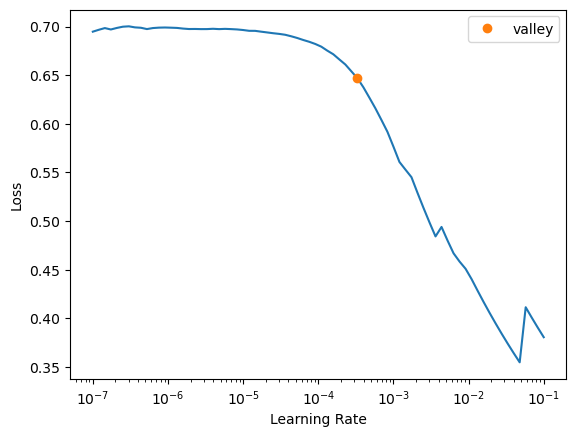

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.035651,0.065737,0.984999,01:24


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1, lr_max=slice(1e-8, 1e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.047713,0.065211,0.984999,02:23


In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"Everyone tries to hack everyone else. I have no doubt Russia would try to hack even canada. However, the US has been doing the same, if we recall Snowden.\n\nEven Merkel's phone conversations were being tapped by the CIA. \n\nThe real purpose of this issue is political. Trump is upset because people are trying to imply that he didn't deserve his victory, that the Russians helped him. It's an ego thing. Good CEOs sometimes have giant egos. I have no problem with that as long as they produce results, I gladly buy shares in their company.\n\nOtoh, Russia did invade Crimea recently, and their missile brought down a commercial airliner and killed lots of innocent people. The world has a right to be annoyed at the Russians.\n\nIf you want to find evidence of Russians hacking, you will find them. But if you want to find China or some guy in a basement somewhere, I have no doubt you can find the same as well. Whether they succeeded or not, that's hard to prove, but there's lots of blackhats",[],[]
1,"And, just as expected, it's quite alright to slag Catholics on these pages. Civil Comments, yeah sure.\n\n1 poster made a sneering reference is very poor taste 'bout Catholics on another thread, and as predicted, rather than apologizing for something made in poor taste just to slag me, that poster doubled down. Who me? No way. It's the victim who can't take a joke, takes things the wrong way. It's always that way, that's what bullies do, they blame others, their fault.\n\nEven had another poster rush to his defence. Wasn't that just precious? Strength in #s.\n\nCoulds done the proper thing, coulda taken the high road, but no, easier just to feign innocence.\n\nThat's fine, no problem, just hope it's OK to do likewise back at that person, some would say he's a bigot, but I won't go there. A withdraw woulda sufficed, but apparently it's the Catholics fault.\n\nI guess it's OK to use somebody's religion to make a joke and their fault if they can't take the joke.\n\nPretty low, man, pretty low",[],[]


In [ ]:
learn.loss_func.thresh = 0.02

In [ ]:
comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.blurr_predict(comment)

[(((#2) ['insult','toxicity'],),
  (#1) [tensor([False,  True, False,  True, False, False, False])],
  (#1) [tensor([1.8458e-03, 3.0387e-02, 6.5388e-03, 4.3528e-02, 4.7479e-06, 1.5248e-03,
        1.6604e-04])])]

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([2000, 7]), torch.Size([2000, 7]), torch.Size([2000]))

## High-level API

With the high-level API, we can create our DataBlock, DataLoaders, and Blearner in one line of code

In [ ]:
#hide
try: del learn; torch.cuda.empty_cache()
except: pass

/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (__class__) that exists in the learner. Use `self.learn.__class__` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


In [ ]:
learn = BlearnerForSequenceClassification.from_dataframe(toxic_df, pretrained_model_name, 
                                                         text_attr='text', label_attr=lbl_cols, dl_kwargs={'bs': 4})

learn.loss_func.thresh = 0.02

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-2)

epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,0.039158,0.064924,0.000000,0.984999,01:13


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [ ]:
learn.show_results(learner=learn, max_n=2)

/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


,text,target,prediction
0,"Everyone tries to hack everyone else. I have no doubt Russia would try to hack even canada. However, the US has been doing the same, if we recall Snowden.\n\nEven Merkel's phone conversations were being tapped by the CIA. \n\nThe real purpose of this issue is political. Trump is upset because people are trying to imply that he didn't deserve his victory, that the Russians helped him. It's an ego thing. Good CEOs sometimes have giant egos. I have no problem with that as long as they produce results, I gladly buy shares in their company.\n\nOtoh, Russia did invade Crimea recently, and their missile brought down a commercial airliner and killed lots of innocent people. The world has a right to be annoyed at the Russians.\n\nIf you want to find evidence of Russians hacking, you will find them. But if you want to find China or some guy in a basement somewhere, I have no doubt you can find the same as well. Whether they succeeded or not, that's hard to prove, but there's lots of blackhats",[],"[insult, toxicity]"
1,"And, just as expected, it's quite alright to slag Catholics on these pages. Civil Comments, yeah sure.\n\n1 poster made a sneering reference is very poor taste 'bout Catholics on another thread, and as predicted, rather than apologizing for something made in poor taste just to slag me, that poster doubled down. Who me? No way. It's the victim who can't take a joke, takes things the wrong way. It's always that way, that's what bullies do, they blame others, their fault.\n\nEven had another poster rush to his defence. Wasn't that just precious? Strength in #s.\n\nCoulds done the proper thing, coulda taken the high road, but no, easier just to feign innocence.\n\nThat's fine, no problem, just hope it's OK to do likewise back at that person, some would say he's a bigot, but I won't go there. A withdraw woulda sufficed, but apparently it's the Catholics fault.\n\nI guess it's OK to use somebody's religion to make a joke and their fault if they can't take the joke.\n\nPretty low, man, pretty low",[],"[insult, toxicity]"


In [ ]:
comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.blurr_predict(comment)

[(((#2) ['insult','toxicity'],),
  (#1) [tensor([False,  True, False,  True, False, False, False])],
  (#1) [tensor([1.7905e-03, 3.7619e-02, 4.1737e-03, 4.4768e-02, 7.4501e-07, 1.2395e-03,
        5.1651e-04])])]

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


(torch.Size([2000, 7]), torch.Size([2000, 7]), torch.Size([2000]))

## Summary

If your sequence classification model isn't training, make sure you have set the `num_labels` correctly (95% of the time this is the culprit).  And with this example, you can see that Blurr can make both your multiclassification and multilabel classification tasks a breeze.

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
